### Mount Google Drive and create paths

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
import os
WORK_DIR = os.path.join('/content/gdrive/My Drive/Study/Contest_2')
dataset_path = os.path.join(WORK_DIR, 'dataset')

### Import libs

In [30]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
#models
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import tree

#data and model selection
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
#preprocessing
from sklearn.preprocessing import OneHotEncoder

#metrics
from sklearn.metrics import roc_auc_score
from sklearn import metrics

### Load Data

In [31]:
train_path = os.path.join(dataset_path, 'train.csv')
test_path = os.path.join(dataset_path, 'test.csv')

In [32]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [33]:
print(df_train.shape, df_test.shape)
df_train.head()

(307511, 122) (48744, 121)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Data preparation

#### Train

In order to fill in missing values we need to divide features into categorical and numeric first.

In [34]:
num_features = df_train.select_dtypes(exclude = ["object"]).columns
cat_features = df_train.select_dtypes(include = ["object"]).columns

Replacing missing values: most frequent values for strings and median for numerics

In [35]:
most_freq_cat_nans = []
for i in cat_features:
  most_freq_cat_nans.append(df_train[i].value_counts().idxmax())

In [36]:
for i in range(len(cat_features)):
    df_train[cat_features[i]].fillna(most_freq_cat_nans[i], inplace=True)
for i in num_features:
    df_train[i].fillna(df_train[i].median(), inplace=True)

In [37]:
df_train.isna().sum().max()

0

In [38]:
y = df_train['TARGET']

In [39]:
df_train = df_train.drop('TARGET', axis=1)
df_train = df_train.drop('SK_ID_CURR', axis=1)

#### Test

In [40]:
test_ids = df_test['SK_ID_CURR'] # save for submission

In [41]:
df_test = df_test.drop('SK_ID_CURR', axis=1)

Replacing missing values: most frequent values for strings and median for numerics

In [42]:
num_features = df_test.select_dtypes(exclude = ["object"]).columns
cat_features = df_test.select_dtypes(include = ["object"]).columns

In [43]:
most_freq_cat_nans_test = []
for i in cat_features:
    most_freq_cat_nans_test.append(df_test[i].value_counts().idxmax())

In [44]:
for i in range(len(cat_features)):
    df_test[cat_features[i]].fillna(most_freq_cat_nans[i], inplace=True)
for i in num_features:
    df_test[i].fillna(df_test[i].median(), inplace=True)

In [45]:
df_test.isna().sum().max()

0

#### Encoding



In order to encode data properly we should merge tran and test datasets.

In [46]:
train_size = df_train.shape[0]

In [47]:
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)

In [48]:
all_data = pd.get_dummies(all_data, columns = cat_features, dummy_na = True)

Now we can divide data and go on.



In [49]:
train_data = all_data[:train_size]
test_data = all_data[train_size:]

In [50]:
test_data.shape, train_data.shape

((48744, 260), (307511, 260))

### Modelling 1. Decision Tree.

#### Tuning **max_depth**


In [51]:
depth_scores = []

In [40]:
for i in range(5, 10, 1):
    tree_clf = tree.DecisionTreeClassifier(max_depth=i)
    depth_scores.append(cross_val_score(tree_clf, train_data, y, cv=5, scoring='roc_auc').mean())

In [68]:
index_d = [i for i in range(5, 10)]

In [69]:
df_tree_depth = pd.DataFrame(depth_scores, index_d, columns=["ROC AUC"])

In [70]:
df_tree_depth

,ROC AUC
5,0.706838
6,0.711946
7,0.715048
8,0.716925
9,0.715977


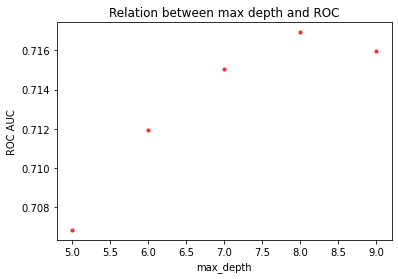

In [71]:
def scatterplot(x_data, y_data, x_label="", y_label="", title="", color = "r", yscale_log=False):
    _, ax = plt.subplots()
    ax.scatter(x_data, y_data, s = 10, color = color, alpha = 0.75)
    
    ax.set_title("Relation between max depth and ROC")
    ax.set_xlabel("max_depth")
    ax.set_ylabel("ROC AUC")

scatterplot(df_tree_depth.index, df_tree_depth["ROC AUC"])

Best ROC score with **max_depth=8**.

#### Tuning **criterion**

In [78]:
criterion_scores = []

In [79]:
criterion = ["gini", "entropy"]

In [80]:
for i in criterion:
    tree_clf_criterion = tree.DecisionTreeClassifier(max_depth=8, criterion=i)
    criterion_scores.append(cross_val_score(tree_clf_criterion, train_data, y, cv=5, scoring='roc_auc').mean())

In [81]:
df_tree_criterion = pd.DataFrame(criterion_scores, criterion, columns=["ROC AUC"])

In [82]:
df_tree_criterion

,ROC AUC
gini,0.717059
entropy,0.711954


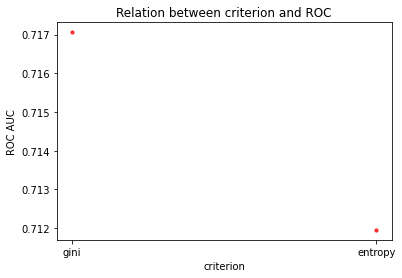

In [84]:
def scatterplot(x_data, y_data, x_label="", y_label="", title="", color = "r", yscale_log=False):
    _, ax = plt.subplots()
    ax.scatter(x_data, y_data, s = 10, color = color, alpha = 0.75)
    
    ax.set_title("Relation between criterion and ROC")
    ax.set_xlabel("criterion")
    ax.set_ylabel("ROC AUC")

scatterplot(df_tree_criterion.index, df_tree_criterion["ROC AUC"])

Best ROC score with **criterion=gini**.

#### Tuning **min_samples_leaf**

In [95]:
msleaf_scores = []

In [96]:
for i in range(1, 4, 1):
    tree_clf_msleaf = tree.DecisionTreeClassifier(max_depth=8, criterion="gini", min_samples_leaf=i)
    msleaf_scores.append(cross_val_score(tree_clf_msleaf, train_data, y, cv=5, scoring='roc_auc').mean())

In [97]:
index_msleaf = [i for i in range(1, 4)]

In [98]:
df_tree_msleaf = pd.DataFrame(msleaf_scores, index_msleaf, columns=["ROC AUC"])

In [99]:
df_tree_msleaf

,ROC AUC
1,0.716878
2,0.716613
3,0.716447


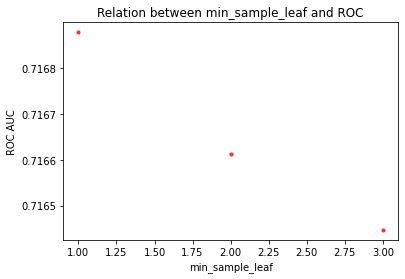

In [100]:
def scatterplot(x_data, y_data, x_label="", y_label="", title="", color = "r", yscale_log=False):
    _, ax = plt.subplots()
    ax.scatter(x_data, y_data, s = 10, color = color, alpha = 0.75)
    
    ax.set_title("Relation between min_sample_leaf and ROC")
    ax.set_xlabel("min_sample_leaf")
    ax.set_ylabel("ROC AUC")

scatterplot(df_tree_msleaf.index, df_tree_msleaf["ROC AUC"])

Best ROC score with **min_sample_leaf=1**.

#### GridSearchCV

In [ ]:
params_tree = {'criterion':('gini', 'entropy'),
          'max_depth':[6, 7, 8],
          'min_samples_leaf':[1, 2]}

In [ ]:
model_tree = tree.DecisionTreeClassifier()

In [52]:
clf_tree_GS = GridSearchCV(model_tree, params_tree, scoring ='roc_auc', cv=5)
clf_tree_GS.fit(train_data, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ('gini', 'entropy'),
                   

In [53]:
clf_tree_GS.best_params_

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1}

All the parameters are the same as chosen manually.

#### RandomizedSearchCV

In [54]:
clf_tree_RS = RandomizedSearchCV(model_tree, params_tree, scoring ='roc_auc', cv=5)
clf_tree_RS.fit(train_data, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [55]:
clf_tree_RS.best_params_

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1}

All parameters are the same as chosen manually and as chosen by Grid Search.

### Modelling 2. Random Forest.

#### Tuning **n_estimators**

In [66]:
nest_scores = []

In [67]:
for i in range(100, 130, 10):
    rf_clf_nest = RandomForestClassifier(n_estimators=i)
    nest_scores.append(cross_val_score(rf_clf_nest, train_data, y, cv=5, scoring='roc_auc').mean())

In [69]:
index_nest = [i for i in range(100, 130, 10)]

In [70]:
df_rf_nest = pd.DataFrame(nest_scores, index_nest, columns=["ROC AUC"])

In [85]:
df_rf_nest

,ROC AUC
100,0.709856
110,0.712421
120,0.713947


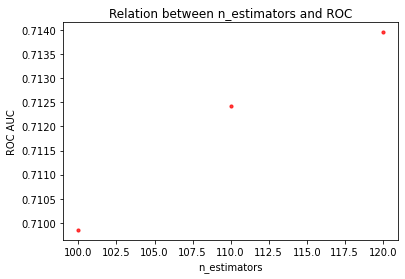

In [71]:
def scatterplot(x_data, y_data, x_label="", y_label="", title="", color = "r", yscale_log=False):
    _, ax = plt.subplots()
    ax.scatter(x_data, y_data, s = 10, color = color, alpha = 0.75)
    
    ax.set_title("Relation between n_estimators and ROC")
    ax.set_xlabel("n_estimators")
    ax.set_ylabel("ROC AUC")

scatterplot(df_rf_nest.index, df_rf_nest["ROC AUC"])

Best ROC score with n_estimators=120. Probably, we should take more trees, but it is going to take much time to fit. Let's try with Grid Search.

#### Tuning **max_depth**

In [72]:
rf_depth_scores = []

In [75]:
for i in range(10, 50, 10):
    rf_clf_depth = RandomForestClassifier(n_estimators=120, max_depth=i)
    rf_depth_scores.append(cross_val_score(rf_clf_depth, train_data, y, cv=5, scoring='roc_auc').mean())

In [76]:
index_rf_d = [i for i in range(10, 50, 10)]

In [77]:
df_rf_depth = pd.DataFrame(rf_depth_scores, index_rf_d, columns=["ROC AUC"])

In [86]:
df_rf_depth

,ROC AUC
10,0.733477
20,0.729029
30,0.717925
40,0.712881


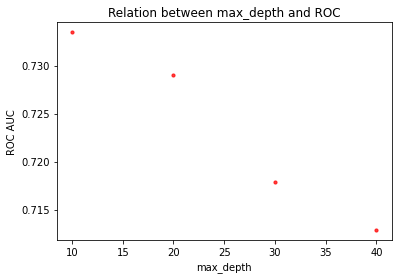

In [78]:
def scatterplot(x_data, y_data, x_label="", y_label="", title="", color = "r", yscale_log=False):
    _, ax = plt.subplots()
    ax.scatter(x_data, y_data, s = 10, color = color, alpha = 0.75)
    
    ax.set_title("Relation between max_depth and ROC")
    ax.set_xlabel("max_depth")
    ax.set_ylabel("ROC AUC")

scatterplot(df_rf_depth.index, df_rf_depth["ROC AUC"])

Best ROC score with max_depth=10. Probably we can get better results with little depth. Let's try with Grid Search.

#### Tuning **min_samples_split**

In [79]:
mssplit_scores = []

In [81]:
for i in range(2, 5):
    rf_clf_mssplit = RandomForestClassifier(n_estimators=120, max_depth=10, min_samples_split=i)
    mssplit_scores.append(cross_val_score(rf_clf_mssplit, train_data, y, cv=5, scoring='roc_auc').mean())

In [82]:
index_mssplit = [i for i in range(2, 5)]

In [83]:
df_mssplit = pd.DataFrame(mssplit_scores, index_mssplit, columns=["ROC AUC"])

In [87]:
df_mssplit

,ROC AUC
2,0.733467
3,0.732959
4,0.733138


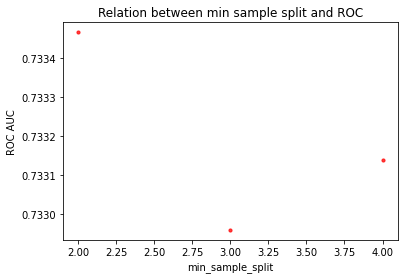

In [89]:
def scatterplot(x_data, y_data, x_label="", y_label="", title="", color = "r", yscale_log=False):
    _, ax = plt.subplots()
    ax.scatter(x_data, y_data, s = 10, color = color, alpha = 0.75)
    
    ax.set_title("Relation between min samples split and ROC")
    ax.set_xlabel("min_samples_split")
    ax.set_ylabel("ROC AUC")

scatterplot(df_mssplit.index, df_mssplit["ROC AUC"])

Best ROC score with min_sample_split=2.

#### GridSearchCV

In [91]:
params_rf = {'n_estimators':[120, 130],
          'max_depth':[9, 10],
          'min_samples_split':[2, 3]}

model_rf = RandomForestClassifier()
clf_GS_rf = GridSearchCV(model_rf, params_rf, scoring ='roc_auc', cv=5)
clf_GS_rf.fit(train_data, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [92]:
clf_GS_rf.best_params_

{'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 120}

Max_depth and n_estimaters are the same as found manually. Min_samples_split is different. 

#### RandomizedSearchCV

In [95]:
clf_RS_rf = RandomizedSearchCV(model_rf, params_rf, scoring ='roc_auc', cv=5)
clf_RS_rf.fit(train_data, y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [96]:
clf_RS_rf.best_params_

{'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 130}

Max_depth is the same as chosen manually and via Grid Search. Min_sample_split is different to chosen manually and the same as chosen with Grid Search. Number of n_estimators is different to both.

### Random Forest. Feature importance

In [99]:
final_model = RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=130)
final_model.fit(train_data, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=130,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [101]:
cross_val_score(final_model, train_data, y, cv=5, scoring='roc_auc').mean()

0.7323656326633812

**ROC-AUC with all features is 0.73237**

In [116]:
feature_scores = pd.Series(final_model.feature_importances_, index=train_data.columns).sort_values(ascending=False)

In [118]:
feature_scores.head(10)

EXT_SOURCE_3                            0.154632
EXT_SOURCE_2                            0.144806
EXT_SOURCE_1                            0.059784
DAYS_BIRTH                              0.033783
DAYS_EMPLOYED                           0.031067
DAYS_LAST_PHONE_CHANGE                  0.023567
AMT_GOODS_PRICE                         0.020787
DAYS_ID_PUBLISH                         0.019864
NAME_EDUCATION_TYPE_Higher education    0.017939
AMT_CREDIT                              0.015828
dtype: float64

These features are the most significant.

In [125]:
five_f_model = train_data[['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'DAYS_EMPLOYED']]

In [ ]:
final_model.fit(five_f_model, y)

In [134]:
cross_val_score(final_model, five_f_model, y, cv=5, scoring='roc_auc').mean()

0.7294048427399442

0.72940 VS 0.73236. The result with only most significant features is **worse**.

In [131]:
four_f_model = five_f_model.drop(['EXT_SOURCE_3'], axis=1)

In [135]:
cross_val_score(final_model, four_f_model, y, cv=5, scoring='roc_auc').mean()

0.6933826183960335

Now ROC-AUC score is even worse.